# Convergent Cross Mapping / Sugihara Causality

## Introduction
In the previous chapters we talked about Simplex Projection, a forecasting technique that looks for similar trends in the past to forecast the future by computing for nearest neighbors on an embedding. In this chapter, we discuss  Convergent Cross Mapping (CCM) also formulated by [Sugihara et al., 2012](https://science.sciencemag.org/content/338/6106/496) as a methodology that uses ideas from Simplex Projection to identify causality between variables in a complex dynamical system (e.g. ecosystem) using just time series data.

We will go through the key ideas of CCM, how it addresses, and the algorithm behind it. We will then test the CCM framework on simulated data where we will deliberately adjust the influence of one variable over the other. Finally, we will apply CCM on some real world data to infer the relationships between variables in a system.

### causal-ccm Package
This chapter explains the CCM methodology in detail. If you wish to apply this in your own projects, install the framework using `pip install causal-ccm`. See `using_causal_ccm_package.ipynb` notebook for details how to use.

### Why understand causality?
We define causality as the influence of one variable on another. Understanding causality is important because it allows us to:
* Explain phenomena that they are not necessarily supernatural/paranormal
* Anticipate the future and make the necessary adjustments
* Apply interventions in the system to achieve desired outcomes

### Limitations of Granger Causality
In chapter 4, we talked about a framework for establishing causality in a system called Granger Causality. However Granger Causality has its limitations. 

The intuition behind Granger causality is that a variable A causes B if we have a model that improves prediction of B if we include A. This framework assumes that we can "separate" the information about A from the rest of the system. However, in many systems that have interacting parts, information about a variable may not necessarily be removable from the rest of the system. They are integrated or in other words, not separable.

Granger causality framework does not apply to cases where information about variables are not separable from the rest of the system especially for those whose causalities are weak to moderate (like in our test systems in the following sections). Finally, Granger Causality is dependent on the performance of a linear predictive model that assumes linear combination of variables. This model may not perform well for some systems that need nonlinear models to improve predictions.

### CCM addresses limits of Granger's causality
Convergent Cross Mapping is designed to identify and quantify causalities in systems whose variables are not separable. Beyond this, it is designed to identify and quantify weak to moderate causalities, which Granger Causality may miss. Finally, CCM is independent of a predictive model so we're not at the mercy of model performance.

## Related Concepts
We briefly discuss key concepts related to CCM.

### Deterministic Dynamical Systems
"Deterministic" means there's no randomness in the system (even if it may look random, e.g. chaos). "Dynamical" means the values or "states" of the system change over time. "System" means it's a set of things that interact with each other.

### Attractors
<img src=https://fromsystosys.netlify.com/img/lorenz_custom_pers_small.gif>
An attractor is a "space" of states that the system tends to get attracted to as time goes on. When attractors can be thought of as curved spaces, they are called "manifolds." I like to think of attractors as a way to summarize our system, like an embedding layer in a neural network architecture. 

*Q: What do you think is the simplest type of attractor?*

### Takens' Embedding Theorem and Shadow Manifolds
<img src = https://www.researchgate.net/profile/Pablo_Verdes/publication/51595532/figure/fig4/AS:305687352627206@1449892952960/Color-online-Schematic-representation-of-the-measurement-process-and-reconstruction-of.png width=500>
Uzal, Lucas & Grinblat, G & Verdes, Pablo. (2011). Optimal reconstruction of dynamical systems: A noise amplification approach. Physical review. E, Statistical, nonlinear, and soft matter physics. 84. 016223. 10.1103/PhysRevE.84.016223. 

From the term "shadow", shadow manifolds are "projections" of the true system manifold on some variable $X$. What Takens' theorem tells us is if $X$ belongs to a system $S$ then we can generate a shadow manifold of the true manifold $M_s$ using vectors of lagged (historical) values of $X$. The points in this shadow manifold $M_x$ will have a 1:1 correspondence with the points in the true (unknown) manifold $M_s$.

## How and why does CCM work?

<img src=https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-58895-7_27/MediaObjects/429072_1_En_27_Fig1_HTML.gif width=400>
Tsonis A.A., Deyle E.R., Ye H., Sugihara G. (2018) Convergent Cross Mapping: Theory and an Example. In: Tsonis A. (eds) Advances in Nonlinear Geosciences. Springer, Cham. https://doi.org/10.1007/978-3-319-58895-7_27

### Why Cross Mapping?
In a system $Y=f(X,Y)$, cross Mapping means given the points on the manifold of one variable $M_y$, we look for the corresponding points on $M_x$, i.e. points at the same time $t$.

If $X$ causes $Y$, then we say some information about $X$ gets stored in $Y$. If this is the case, then we can predict the values of $X$ given values from $Y$. Note that this sounds counter intuitive. We contrast this with Granger causality which says that $X$ causes $Y$ if we can predict $Y$ better given $X$.

We use shadow manifolds because we do not know the true manifold of the system. Given Takens' theorem however, we can say that we can compute shadow manifolds $M_x$ and $M_y$ which then cross map with 1:1 correspondence to the true manifold of the system.

If we use the analogy that manifolds are "summaries" of system, we can think of $M_x$ and $M_y$ as summaries of $X$ and $Y$. If $X$ causes $Y$, information from $X$ gets embedded in $Y$. It follows that we can then use $M_x$ to predict $Y$, i.e. $\hat{Y}|M_x$. Finally, we can use the "accuracy" (MAE, MSE, or correlation) of this prediction as our metric for causality. 

### Why Convergence?
Convergence in CCM means that for variables with causalities, the longer our observation period (or more data we gather), the better we can predict one variable using the other. In the attractor example above, we can imagine the attractor will get denser as time goes on since our system will eventually fill in some of the gaps in the manifold. Stated another way, more defined manifolds imply that for variables with causalities, we can expect the accuracy of $\hat{Y}|M_x$ to improve. If two variables have no causal link, then improving their manifolds will not translate to improvement in predictions.

Cross mapping and convergence are two requirements in the CCM framework that we need to satisfy to consider the possiblity of causality between variables.

## Defining our Sample System

We show here a sample nonlinear system. Here, we explicitly defined $X$ to be influenced by $Y$ and vice versa. The effect of $X$ on $Y$ is a factor of $\beta_{y,x}$ and the effect of $Y$ on $X$ is a factor of $\beta_{x,y}$. One way to read $\beta_{y,x}$: "the influence of $x$ on $y$". $r_x$ and $r_y$ are some constants that affect how chaotic the system is. As we increase $r$ say $r > 3.5$ we get more unpredictable ("chaotic") behavior.

$X(t+1)=X(t)[r_x-r_xX_t-\beta_{x,y}Y(t)]$
<br>$Y(t+1)=Y(t)[r_y-r_yY_t-\beta_{y,x}X(t)]$

Key questions to keep in mind are:
* Can we detect the causality or interaction between these two variables by looking at the correlation between them?
* Can convergent cross mapping help us find this out?

In [1]:
import jdc # used fo defining functions for a class in separate cells
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr

In [2]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

In [3]:
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

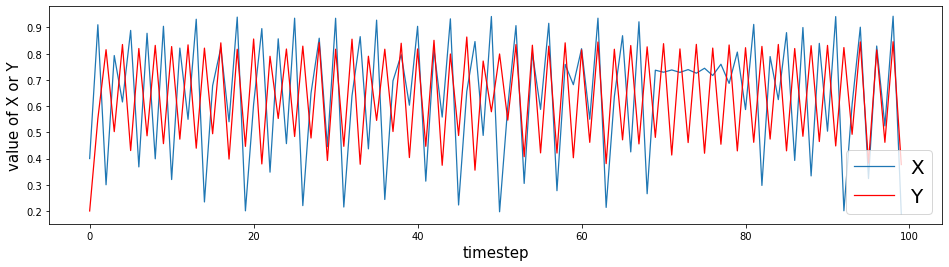

In [4]:
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})

**Discussion**

* Is the system chaotic or random? Say got these data the first time without knowing the equations, which tests can we apply to check if the system is chaotic or random?
* What conclusions about causality can we infer from this plot?

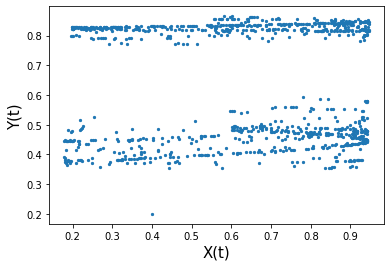

(0.005395539983091767, 0.8646878689811068)

In [5]:
# correlations in the first 1000 time steps
max_t = 1000
x, y = X[:max_t], Y[:max_t]
plt.scatter(x, y, s=5)
plt.xlabel('X(t)', size=15)
plt.ylabel('Y(t)', size=15)
plt.show()
r, p = pearsonr(x, y)
r, p

**Discussion**

* Though we explicitly defined $Y$ to be a function of $X$ ($X$ influences $Y$), we find no correlation between them in the long term. 
* Based on this correlation value, what can we conclude about the relationship between $X$ and $Y$ (e.g. whether or not $X$ influences $Y$ or vice versa)?

## CCM Algorithm

1. Given two time series 

<center>$X = \{X(1), X(2), ..., X(L)\}$ and $Y = \{Y(1), Y(2), ..., Y(L)\}$ where $L$ is time series length</center>

2. Compute lagged-coordinate vectors where $E$ is an "embedding" dimension. Search algorithms e.g. grid search can be used to identify what the best $E$ value is. $\tau$ is the lag step.

<center>$\underline{x}(t) = <X(t), X(t-\tau), X(t-2\tau), ..., X(t-(E-1)\tau)>$ for $t \in [1+(E-1)\tau, L]$</center>

3. Define the "shadow (attractor) manifold" $M_x = \{\underline{x}(t) \text{ for each } t \in [1+(E-1)\tau, L]\}$
4. At $t$, locate $\underline{x}(t)$ in $M_x$
5. Find the $E+1$ nearest neighbor vectors from selected vector $\underline{x}(t)$. Sugihara, et al. noted that $E+1$ is the minimum number of points needed for an "embedding/simplex" with $E$ dimensions. Intuitively, if you have a 2D matrix, you need 3 points (2 + 1) to "triangulate" a point
6. Denote the time indices of the $E+1$ nearest neighbors of $\underline{x}(t)$ by $t_1, ..., t_{E+1}$. These indices will be used to identify the corresponding points in $Y$.
7. Define the model that predicts $Y$ given $M_x$ as $\hat{Y} | M_x = \Sigma{w_iY(t_i)}$ where $i = 1 ... E+1$ where $w_i$ is the weight that we multiply by the corresponding $Y(t_i)$
    * $w_i = u_i / \Sigma{u_j}$ where $j = 1...E+1$
    * $u_i = exp[-d(\underline{x}(t), \underline{x}(t_i))/d(\underline{x}(t), \underline{x}(t_1))]$ where $d(\underline{x}(s), \underline{x}(t))$ is a Euclidean distance. Note that we divide by $d(x(t), x(t_1))$ to "scale" the distances as a multiples of the distance to the closest point. The intuition here is the farther away the neighbor, the lower the weight by some $exp^-k$
8. If $X$ and $Y$ are dynamically "coupled" i.e. one influences the other, a clump of points in $M_x$ should correspond to a clump of points in $M_y$. And as $L$ increases, we get a denser cluster of $E+1$ points from $M_x$ that correspond to a denser cluster of points in $M_y$. Given this, $\hat{Y} | M_x$ intuitively should converge to $Y$ as $L$ increases, e.g. we get more data/samples. Hence, we can test for convergence of the nearest neighbors to test for correspondence between states on $M_x$ and $M_y$.
9. We then plot the correlation coefficients between $Y$ and $\hat{Y} | M_x$. If there is significant correlation, this means we have enough information from $Y$ that is stored in $X$. We say that $Y$ influences $X$. It sounds counter intuitive but another way to think about it is: if $Y$ influences $X$ then information from $Y$ gets stored in $X$. We can thus use $X$ to predict $Y$. Same goes for $X$ influencing $Y$.

### Defining CCM Functions

In [6]:
# Computing "Causality" (Correlation between True and Predictions)

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold    

In [7]:
%%add_to ccm
def shadow_manifold(self, X):
    """
    Given
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
    for t in range((self.E-1) * self.tau, self.L):
        x_lag = [] # lagged values
        for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*self.tau])            
        M[t] = x_lag
    return M

In [8]:
%%add_to ccm

# get pairwise distances between vectors in X
def get_distances(self, Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [9]:
%%add_to ccm

def get_nearest_distances(self, t, t_steps, dists):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances


In [10]:
%%add_to ccm
def predict(self, t):
    """
    Args
        t: timestep at Mx to predict Y at same time step
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """
    eps = 0.000001 # epsilon minimum distance possible
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
    
    # get weights
    u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat
    
    return X_true, X_hat
    
    

In [11]:
%%add_to ccm
def causality(self):
    '''
    Args:
        None
    Returns:
        correl: how much self.X causes self.Y. correlation between predicted Y and true Y
    '''

    # run over all timesteps in M
    # X causes Y, we can predict X using My
    # X puts some info into Y that we can use to reverse engineer X from Y        
    X_true_list = []
    X_hat_list = []

    for t in list(self.My.keys()): # for each time step in My
        X_true, X_hat = self.predict(t) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat) 

    x, y = X_true_list, X_hat_list
    r, p = pearsonr(x, y)        

    return r, p


### Functions for Visualizing

In [12]:
%%add_to ccm

def visualize_cross_mapping(self):
    """
    Visualize the shadow manifolds and some cross mappings
    """
    # we want to check cross mapping from Mx to My and My to Mx

    f, axs = plt.subplots(1, 2, figsize=(12, 6))        
    
    for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
        #===============================================
        # Shadow Manifolds Visualization

        X_lag, Y_lag = [], []
        for t in range(1, len(self.X)):
            X_lag.append(X[t-tau])
            Y_lag.append(Y[t-tau])    
        X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

        ax.scatter(X_t, X_lag, s=5, label='$M_x$')
        ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

        #===============================================
        # Cross Mapping Visualization

        A, B = [(self.Y, self.X), (self.X, self.Y)][i]
        cm_direction = ['Mx to My', 'My to Mx'][i]

        Ma = self.shadow_manifold(A)
        Mb = self.shadow_manifold(B)

        t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
        t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

        # Plot cross mapping for different time steps
        timesteps = list(Ma.keys())
        for t in np.random.choice(timesteps, size=3, replace=False):
            Ma_t = Ma[t]
            near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

            for i in range(E+1):
                # points on Ma
                A_t = Ma[near_t_A[i]][0]
                A_lag = Ma[near_t_A[i]][1]
                ax.scatter(A_t, A_lag, c='b', marker='s')

                # corresponding points on Mb
                B_t = Mb[near_t_A[i]][0]
                B_lag = Mb[near_t_A[i]][1]
                ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                # connections
                ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

        ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
        ax.legend(prop={'size': 14})

        ax.set_xlabel('$X_t$, $Y_t$', size=15)
        ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
    plt.show()       

In [13]:
%%add_to ccm
def plot_ccm_correls(self):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = self.shadow_manifold(self.Y) # shadow manifold
    t_steps, dists = self.get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
    
    axs[0].scatter(X_My_true, X_My_pred, s=10)
    axs[0].set_xlabel('$X(t)$ (observed)', size=15)
    axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=15)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')

    # predicting Y from Mx
    r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
    
    axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
    axs[1].set_xlabel('$Y(t)$ (observed)', size=15)
    axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=15)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')
    plt.show()


## Applying CCM to our Sample Systems

### Can CCM predict causality in our test system?
Remember our test system is:

$X(t+1)=X(t)[r_x-r_xX_t-\beta_{x,y}Y(t)]$
<br>$Y(t+1)=Y(t)[r_y-r_yY_t-\beta_{y,x}X(t)]$

In [14]:
# Initialize test dataset
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

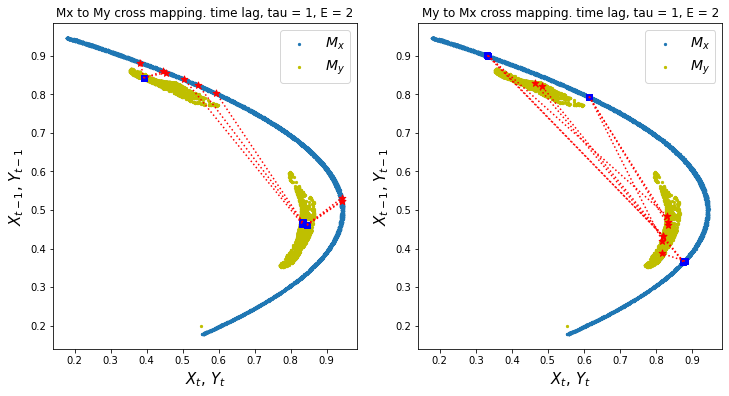

In [15]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = 500 # length of time period to consider

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

**Discussion**

* In the shadow manifolds above, we show the cross mapping of points from one manifold (blue box) to the corresponding points on the other manifold (red star)
* If values from one manifold e.g. $M_x$ make a spread out cross mapping to values on another manifold e.g. $M_y$, this means that we are not able to precisely predict $M_y$ or $Y$ given $M_x$. This implies that not much information from $Y$ is transferred to $X$ to make highly precise predictions. In other words, $Y$ may drive $X$ but not by much.
* What is the implication on causality if the cross mapping is more narrow, e.g. cross mapping $M_x$ from $M_y$ (left chart)

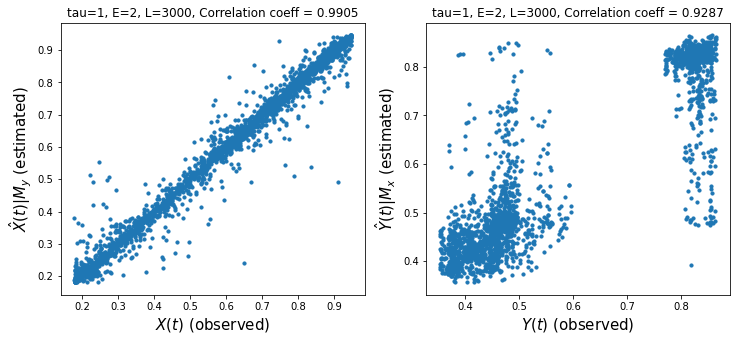

In [16]:
# let us plot the performance of the cross mapping predictions using correlation
L = 3000
tau = 1
E = 2
ccm1.plot_ccm_correls()

**Discussion**
* Based on these plots which variable has more influence over the other i.e. causes the other more?
* We have shown cross-mapping in both directions though one direction is stronger. However, in the CCM framework, the existence of cross-mapping from say X to Y or Y to X is not sufficient to establish causality. We also need to satisfy convergence which we will discuss next.

100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


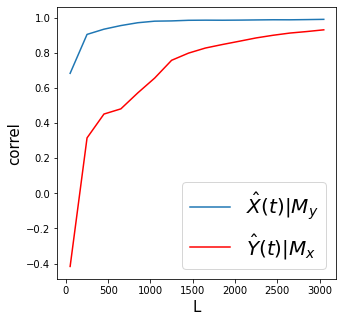

In [17]:
# Looking at "convergence"
L_range = range(50, 3200, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})    

**Discussion**
* Convergence means we are able to improve cross mapping accuracy the longer the period $L$ we consider. To recap, this happens only when we are able to enhance our reconstruction of the shared attractor between two variables using more data.
* In the plot above, we find that both cross mappings converge, however one converges more than the other. We have satisfied the two criteria for CCM: convergence and cross mapping. We can thus say causality exists. However, the magnitudes of causality going from one direction or the other are different. 
* What can we conclude from this plot about the interactions between $X$ and $Y$?
* Which variable has more influence on the other?

### How Betas Affect Causality As Indicated By Convergence

In [18]:
# Checking convergence for various betas
# params
X0 = 0.4 # initial val
Y0 = 0.4 # initial val
t = 400 # time steps for the dataset
L = 400 # time steps for computing CCM
E = 2 # embedding dimensions

range_ = list(np.arange(0, 0.41, 0.02)) # B ranges
correl_diffs = np.zeros(shape=(len(range_), len(range_))) # correlation list
np.random.seed(42)

for ind_B_xy in tqdm(range(len(range_))): # effect on x given y (effect of y on x)
    for ind_B_yx in range(len(range_)): # effect on y given x (effect of x on y)
        
        r_x = np.random.choice(np.arange(3.6, 4.1, 0.01)) # paper implies random sampling
        r_y = np.random.choice(np.arange(3.6, 4.1, 0.01)) # paper implies random sampling

        B_xy = range_[ind_B_xy]
        B_yx = range_[ind_B_yx]
        
        # initialize dataset
        X, Y = [X0], [Y0]
        for i in range(t):
            X_ = func_1(X[-1], Y[-1], r_x, B_xy)
            Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
            X.append(X_)
            Y.append(Y_)

        # there are some combinations that throw an error
        # couldn't find the cause but to be fair, Sugihara et al also had "holes" in their chart
        try:
            # Testing for X -> Y
            ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object
            correl_xy = ccm_XY.causality()[0]          

            # Testing for Y -> X
            ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object
            correl_yx = ccm_YX.causality()[0]

            # get diffs 
            correl_diffs[ind_B_yx][ind_B_xy] = correl_yx - correl_xy # (y -> x) - (x-> y)
        except:
            continue

  0%|          | 0/21 [00:00<?, ?it/s]/Users/prince.javier/opt/anaconda3/envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/Users/prince.javier/opt/anaconda3/envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/prince.javier/opt/anaconda3/envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
  5%|▍         | 1/21 [00:01<00:20,  1.02s/it]/Users/prince.javier/opt/anaconda3/envs/atsa/lib/python3.7/site-packages/scipy/stats/stats.py:3929: RuntimeWarning: invalid value encountered in subtract
  xm = x.astype(dtype) - xmean
100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


/Users/prince.javier/opt/anaconda3/envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


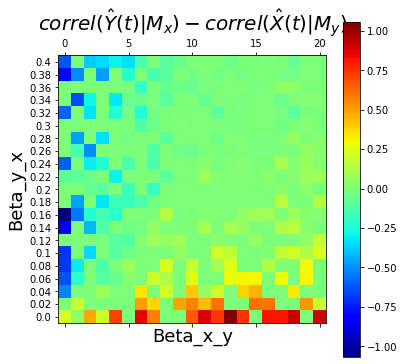

In [19]:
plt.figure(figsize=(6, 6))
plt.matshow(np.nan_to_num(correl_diffs), origin='lower', cmap='jet', fignum=1)
plt.xlabel('Beta_x_y', size=18)
plt.ylabel('Beta_y_x', size=18)
plt.title('$correl(\hat{Y}(t)|M_x) - correl(\hat{X}(t)|M_y$)', size=20)
# plt.xticks(range(len(range_)), np.round(range_, 2), rotation=90)
plt.yticks(range(len(range_)), np.round(range_, 2))
plt.colorbar()
plt.tight_layout()
plt.show()

**Discussion**

The chart above shows the difference in predictive performance $\rho(\hat{Y}|M_x) - \rho(\hat{X}|M_y)$ for different $\beta_{y,x}$ and $\beta_{x,y}$. Remember that $\beta_{y,x}$ is how much $X$ influences $Y$ and that a higher score $\rho(\hat{X}|M_y)$ means we are able to predict $X$ better from $Y$ indicating that much of information from $X$ gets stored in $Y$ or in other words, $X$ causes $Y$. Note that the "spots" in the chart can be due to our randomization of the value of $r_x$ and $r_y$ in each iteration. (We followed the method of randomizing $r$ as implied in the supplemental materials in Sugihara et al's paper. Their chart also has spots.)

* Based on the plot, as $\beta_{y,x}$ increases, what happens to our predicted $\hat{Y}|M_x$ and $\hat{X}|M_y$?
* Do the results align with our intuition that higher $\beta_{y,x}$ means higher effect of $X$ on $Y$?

### What if asymmetrically coupled (the effect is only in one direction)?

Let us define our system as

$X(t+1)=X(t)[3.7-3.7X_t-0Y(t)]$
<br>$Y(t+1)=Y(t)[3.7-3.7Y_t-0.32X(t)]$

Are we convinced that this system has causality in one direction only?

In [20]:
# Initialize test dataset
# params
r_x = 3.7
r_y = 3.7
B_xy = 0 # effect on x given y (effect of y on x)
B_yx = 0.32 # effect on y given x (effect of x on y)

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 3000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

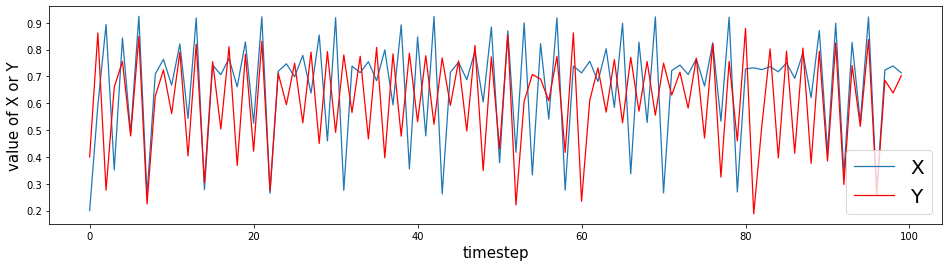

In [21]:
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})

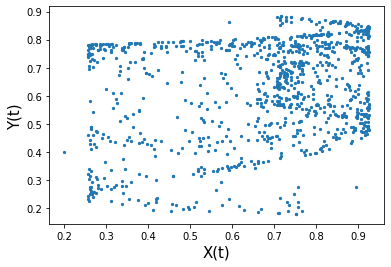

(0.24813484131913205, 1.6963889777956713e-15)

In [22]:
# correlations in the first 1000 time steps
max_t = 1000
x, y = X[:max_t], Y[:max_t]
plt.scatter(x, y, s=5)
plt.xlabel('X(t)', size=15)
plt.ylabel('Y(t)', size=15)
plt.show()
# np.corrcoef(x, y)[0][1]
r, p = pearsonr(x, y)
r, p

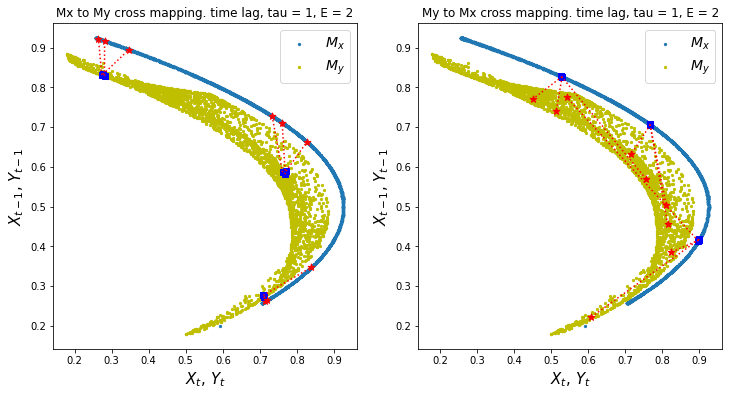

In [23]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(42) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = 500 # length of time period to consider

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

**Discussion**
* What can you observe about the cross mappings between the two manifolds in this system? Remember that the direction of cross mapping is from the blue squares to the red stars
* Is this something that we expected?

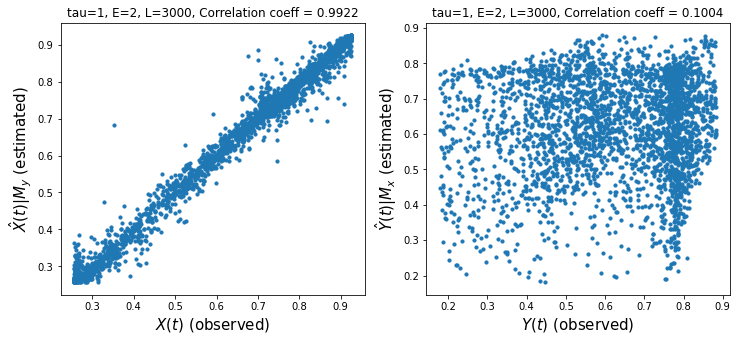

In [24]:
# let us plot the performance of the cross mapping predictions using correlation
L = 3000
tau = 1
E = 2
ccm1.plot_ccm_correls()

100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


X->Y r 0.99 p value 0.0
Y->X r 0.09 p value 0.0


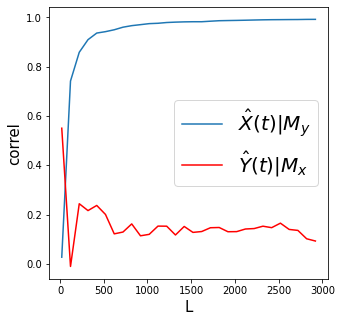

In [25]:
# Looking at "convergence"
L_range = range(20, 3000, 100) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**
* How do we interpret these charts in the context of determining causality using the CCM framework? 
* Are the results here expected? 

## Effect of "Strong Forcing"
What happens to the result of CCM when $X$ has very strong effects on $Y$ yet $Y$ has 0 effect on $X$?

$X(t+1)=X(t)[3.7-3.7X_t-0Y(t)]$
<br>$Y(t+1)=Y(t)[3.7-3.7Y_t- \beta_{yx} X(t)] \text{ where } \beta_{yx} \text{is large}$

In [26]:
# Initialize test dataset
# params

# values for B_yx
# we query an array using B_yx_dict[B_yx value][X or Y]
B_yx_dict = {np.round(k, 2):{'X':[], 'Y':[]} for k in np.arange(0, 1.6, 0.2)}

r_x = 3.7
r_y = 3.7

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 2000 # time steps

for k in B_yx_dict.keys():    
    B_xy = 0 # effect on x given y (effect of y on x)
    B_yx = k # effect on y given x (effect of x on y)    
    
    X = [X0]
    Y = [Y0]
    for i in range(t):
        X_ = func_1(X[-1], Y[-1], r_x, B_xy)
        Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
        X.append(X_)
        Y.append(Y_) 
    B_yx_dict[k]['X'] += X
    B_yx_dict[k]['Y'] += Y



In [27]:
# Looking at "convergence" for different B_yx values
L_range = range(100, 1000, 100) # L values to test
tau = 1
E = 2

B_yx_list = []
L_list = []
Yhat_Mx_list = []
Xhat_My_list = []


for B_yx in tqdm(B_yx_dict.keys()):
    X = B_yx_dict[B_yx]['X']
    Y = B_yx_dict[B_yx]['Y']    

    for L in L_range: 
        ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
        ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
        
        B_yx_list.append(B_yx)
        L_list.append(L)
        Xhat_My_list.append(ccm_XY.causality()[0]) # wont be used        
        Yhat_Mx_list.append(ccm_YX.causality()[0])

100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


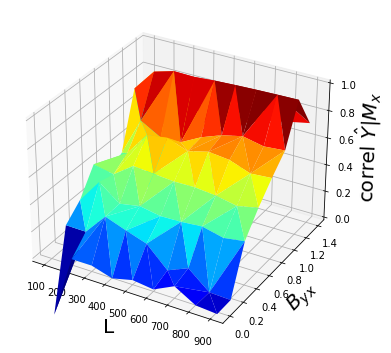

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

x = np.array(L_list)
y = np.array(B_yx_list)
z = np.array(Yhat_Mx_list)

ax.plot_trisurf(x, y, z, cmap='jet', antialiased=True)
ax.set_xlabel('L', size=20)
ax.set_ylabel('$B_{yx}$', size=20)
ax.set_zlabel('correl $\hat{Y}|M_x$', size=20)
ax.set_zlim(0, 1)
plt.tight_layout()


**Discussion**
* Remember that if $Y$ causes $X$, information from $Y$ is embedded in $X$ and we should be able to predict $Y$ given the shadow manifold $M_x$.
* We find that despite $Y$ having no influence on $X$, CCM gives a high cross mapping performance if the influence of $X$ on $Y$, $\beta_{yx}$ is very high. This is what we call "strong forcing." An intuition here is if the effect of $X$ on $Y$ is too high, $Y$ tends to look a lot likt $X$ and thus $M_x$ becomes easier to cross map to $M_y$, which shouldn't be the case. We can thus be misled to think bidirectional causality exists when it doesn't.
* What are the implications when using CCM to infer causality?

## Application in Real World Systems
Here, we apply CCM on real world systems to infer relationships between variables.

In [29]:
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    r, p = np.round(pearsonr(df[val1_name], df[val2_name]), 4)
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='', c='b', linestyle='', legend=False, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='', c='r', linestyle='', legend=False, ax=ax2)
    ax2.set_ylabel(val2_name)    
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}", size=16)
    plt.tight_layout()
    plt.show()

### Nicolas Cage Films and Number of Drowned Victims in the US
We check how much the number of drowned victims in the US affect the number of Nicolas Cage Films for the year and vice versa. Do we expect these two to be causally linked?

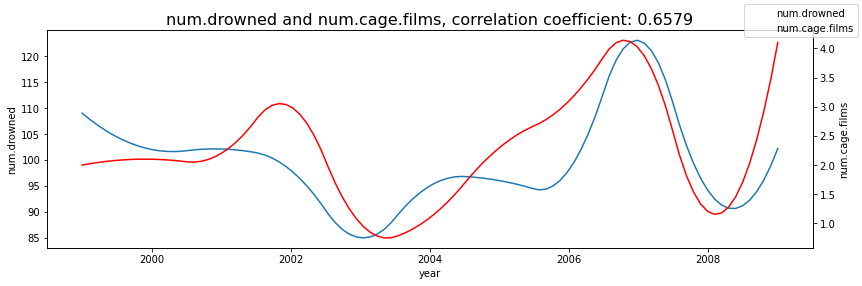

In [30]:
df = pd.read_csv('data/chart2.csv')
df['year'] = range(1999, 2010)
make_plots(df, 'year', 'num.drowned', 'num.cage.films')

100%|██████████| 9/9 [00:00<00:00, 1116.63it/s]


X->Y r 0.21 p value 0.55
Y->X r -0.11 p value 0.77


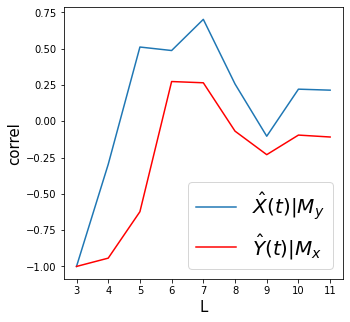

In [31]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['num.cage.films'].values
X = df['num.drowned'].values

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})  

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**

Although for time period up to 7, it might look like there is convergence as shown by improvement in crossmapping correlation, proceeding further results in drop in convergence. We conclude that these two variables are not causally linked.

### Dam System

We then look at two dam systems in the Philippines: Angat Dam and Ipo Dam as well as rainfall and irrigation water flow rate (NIA).

#### Angat Dam vs Rain

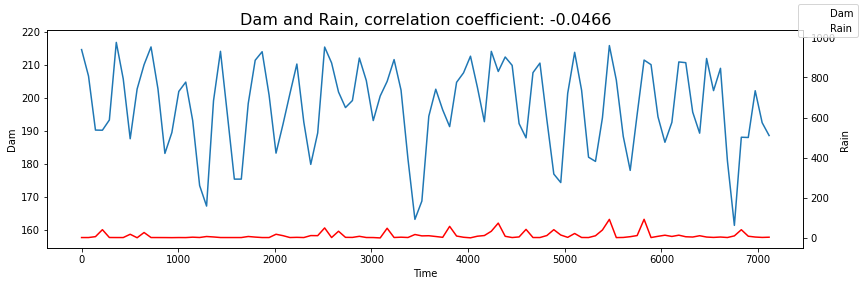

In [32]:
# Num Angat Dam Level vs NIA (what is NIA?)
df = pd.read_csv('data/Angat_dataset.csv')
make_plots(df, 'Time', 'Dam', 'Rain')

100%|██████████| 71/71 [02:26<00:00,  2.07s/it]


X->Y r 0.25 p value 0.0
Y->X r 0.17 p value 0.0


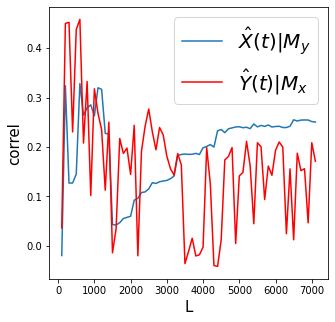

In [33]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['Dam'].values
X = df['Rain'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))


**Discussion**

Rain's effect on dam levels shows some convergence as we increase the time period $L$. However, convergence is not clear on the effect of dam level on rain.

#### Angat Dam vs NIA

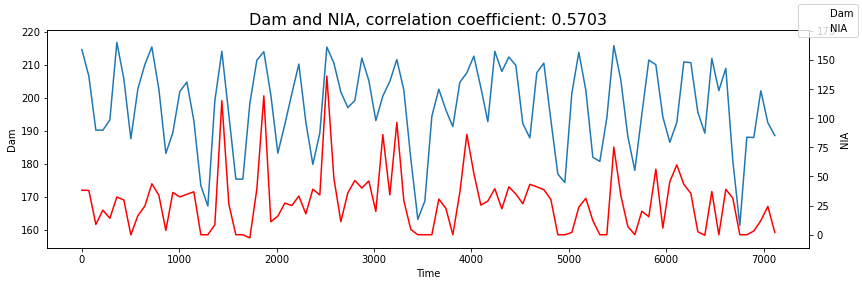

In [34]:
# Num Angat Dam Level vs NIA (what is NIA?)
df = pd.read_csv('data/Angat_dataset.csv')
make_plots(df, 'Time', 'Dam', 'NIA')

100%|██████████| 71/71 [02:32<00:00,  2.15s/it]


X->Y r 0.59 p value 0.0
Y->X r 0.65 p value 0.0


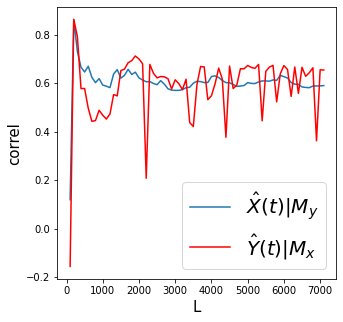

In [35]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['Dam'].values
X = df['NIA'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**

Convergence is cleaner for the effect of irrigation water flow on Dam level. However there is still a rather noisy convergence for the effect of dam level on irrigation water flow.

#### Ipo Dam vs Rain

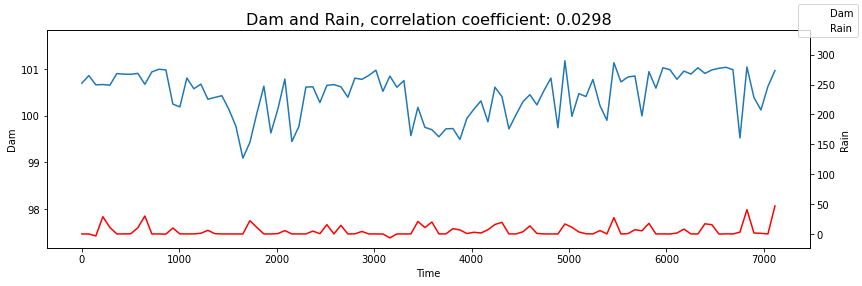

In [36]:
# Num Ipo Dam Level vs NIA (what is NIA?)
df = pd.read_csv('data/Ipo_dataset.csv')
make_plots(df, 'Time', 'Dam', 'Rain')

100%|██████████| 71/71 [02:37<00:00,  2.22s/it]


X->Y r 0.3 p value 0.0
Y->X r 0.05 p value 0.0


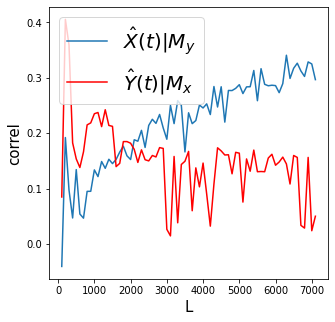

In [37]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['Dam'].values
X = df['Rain'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**

Convergence is clear for the effect of rain on dam levels. Meanwhile there is no convergence for the effect of dam levels on rain.

#### Ipo Dam vs NIA

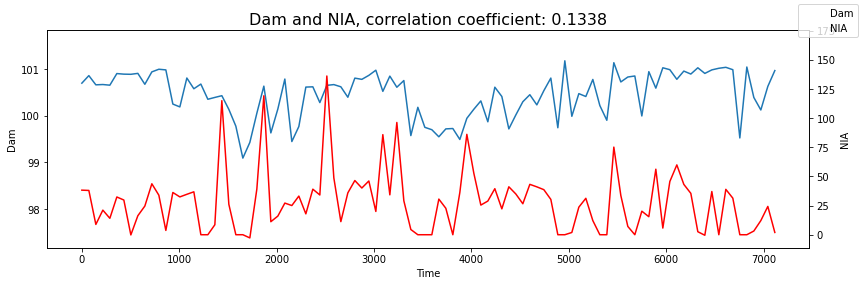

In [38]:
# Num Ipo Dam Level vs NIA (what is NIA?)
df = pd.read_csv('data/Ipo_dataset.csv')
make_plots(df, 'Time', 'Dam', 'NIA')

100%|██████████| 71/71 [02:43<00:00,  2.30s/it]


X->Y r 0.31 p value 0.0
Y->X r 0.21 p value 0.0


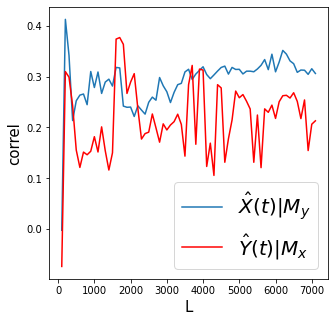

In [39]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['Dam'].values
X = df['NIA'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**

Convergence is clear for the effect of irrigation water flow on dam levels but it is not clear for the effect of dam levels on irrigation water flow.

#### Ipo Dam vs Angat Dam

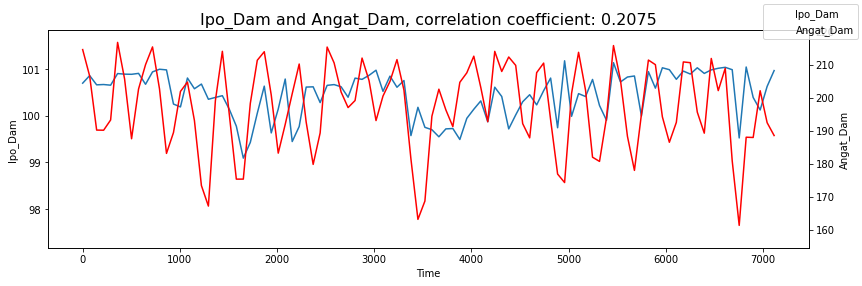

In [40]:
# Num Ipo Dam Level vs Angat Dam Level
df1 = pd.read_csv('data/Ipo_dataset.csv')[['Time', 'Dam']]
df1.rename(columns={'Dam':'Ipo_Dam'}, inplace=True)
df2 = pd.read_csv('data/Angat_dataset.csv')[['Time', 'Dam']]
df2.rename(columns={'Dam':'Angat_Dam'}, inplace=True)
df = df1.merge(df2, on='Time')
make_plots(df, 'Time', 'Ipo_Dam', 'Angat_Dam')

100%|██████████| 71/71 [02:42<00:00,  2.29s/it]


X->Y r 0.33 p value 0.0
Y->X r 0.2 p value 0.0


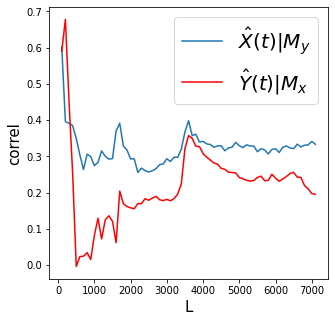

In [41]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['Ipo_Dam'].values
X = df['Angat_Dam'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**

The effect of Angat dam level is stronger on Ipo than the reverse. Also note that convergence is not clear for the effect of Ipo dam level on Angat dam level.

### Dam System Inferred Causal Relationships
Based on the results above, we can infer a network of causal relationships. Relationships with unclear convergence are shown in broken lines while relationships with clear convergence are shown in solid lines. 
<img src='media/dam_inferred_causality.png' width=400>

### Climate change
Here, we look at climate data taken from climate.nasa.gov.

#### CO2 emissions, global temperature, and arctic ice area (Non-ecological)

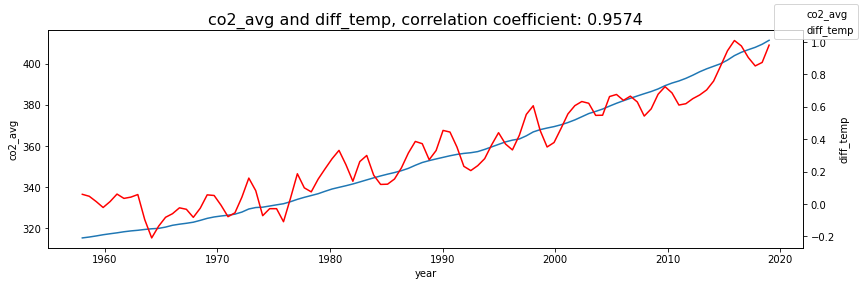

In [42]:
df = pd.read_csv('data/co2_temp - combined.csv')
make_plots(df, 'year', 'co2_avg', 'diff_temp')

100%|██████████| 60/60 [00:00<00:00, 249.06it/s]


X->Y r 0.96 p value 0.0
Y->X r 0.95 p value 0.0


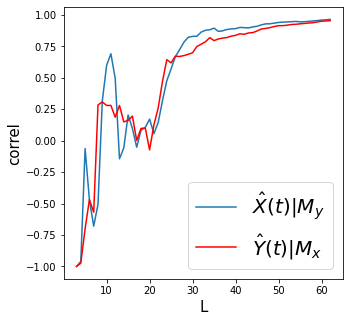

In [43]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

X = df['co2_avg'].values
Y = df['diff_temp'].values

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})    

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

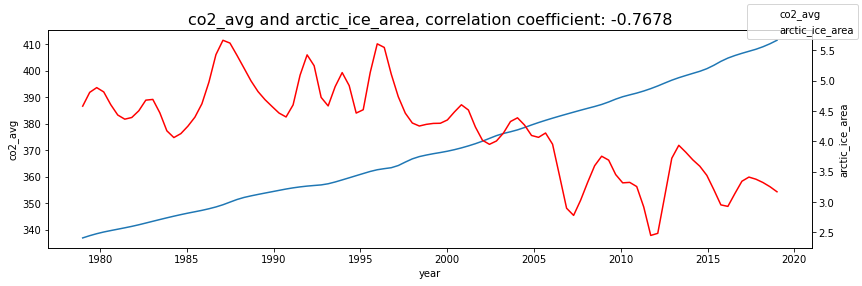

In [44]:
df2 = df.dropna()
make_plots(df2, 'year', 'co2_avg', 'arctic_ice_area')

100%|██████████| 39/39 [00:00<00:00, 448.92it/s]


X->Y r 0.76 p value 0.0
Y->X r 0.8 p value 0.0


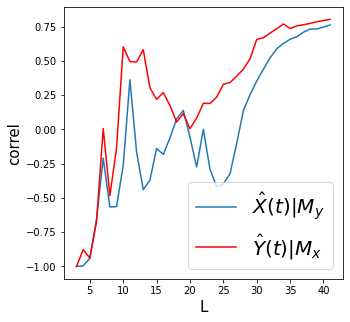

In [45]:
X = df2['co2_avg'].values
Y = df2['arctic_ice_area'].values

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

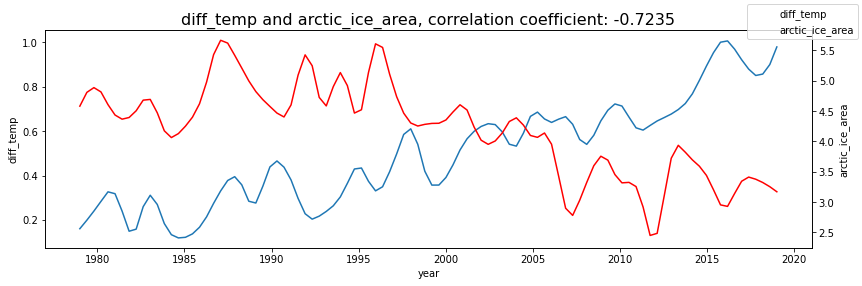

In [46]:
df2 = df.dropna()
make_plots(df2, 'year', 'diff_temp', 'arctic_ice_area')

100%|██████████| 39/39 [00:00<00:00, 459.25it/s]


X->Y r 0.58 p value 0.0
Y->X r 0.69 p value 0.0


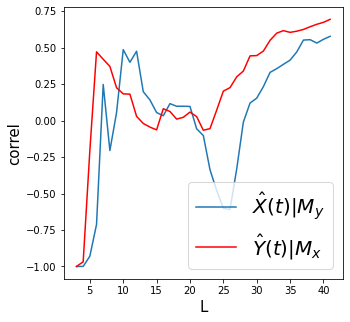

In [47]:
X = df2['diff_temp'].values
Y = df2['arctic_ice_area'].values

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

**Discussion**
* We find strong convergence for all variables above.
* How do we interpret the plots above? Did we meet the requirement of convergent cross mapping (convergence and cross mapping) to say there's causality between each pair of variables?
* How do we relate the concept of "strong forcing" on how we interpret the results?




### Inferred Climate System Causal Relationships

<img src='media/climate_causality.png' width=400>
Based on the results above, we can infer a network of causal relationships. There seems to be a strong feedback loops between all three elements in the system. Upon checking past researches on the topic, we find that there are papers that support the seemingly unintuitive interactions in the inferred causal network:

* [Evolution of South Atlantic density and chemical stratification across the last deglaciation](https://www.pnas.org/content/113/3/514)
* [Arctic sea ice helps remove carbon dioxide from atmosphere, study shows](https://www.sciencedaily.com/releases/2014/09/140922110424.htm)
* [Carbon dioxide enhances fragility of ice crystals](https://iopscience.iop.org/article/10.1088/0022-3727/45/44/445302)
* [How carbon dioxide melted the world](https://www.nature.com/news/how-carbon-dioxide-melted-the-world-1.10393)

## Limitations
We have shown how CCM can be a powerful tool for quantifying causalities between variables by using just time series data. However, the CCM has some limitations that we need to acknowledge:
* The methodology was formulated assuming we are dealing with deterministic systems (no randomness involved)
* The real world can be noisy and we rarely encounter systems that are exactly like their mathematical formulations, so results from the model is better understood as approximations than precise values but precision can improve with more data (increasing $L$)
* When "strong forcing" exists between two variables, bidirectional convergent cross mapping may still happen despite lack of causality. We must rule out strong forcing before we can explore if two variables have causality.

## References
**Main references**
* [Sugihara, G. et al., 2012. Detecting Causality in Complex Ecosystems. Science, 338(6106), pp.496-500.](https://science.sciencemag.org/content/338/6106/496)
* [Sugihara, G. et al., 2012. Supplementary Materials. [online] Science.](https://science.sciencemag.org/content/suppl/2012/09/19/science.1227079.DC1)

**Supplementary materials**
* [SI: Step-by-step EDM Analysis. PNAS](https://www.pnas.org/content/pnas/suppl/2016/10/26/1607747113.DCSupplemental/pnas.1607747113.sapp.pdf)
* [Daon, Y., 2018. Simplex and S-map Algorithms. Comprehensive R Archive Network](https://cran.microsoft.com/snapshot/2018-07-06/web/packages/rEDM/vignettes/rEDM-algorithms.pdf)
* [Petchey, O., 2016. Simplex projection walkthrough. Zurich Open Repository Archive](https://www.zora.uzh.ch/id/eprint/129395/1/Simplex_projection_walkthrough.pdf)
* [Mønster, D. et al., 2016. Inferring causality from noisy time series data
A test of Convergent Cross-Mapping. arXiv](https://arxiv.org/pdf/1603.01155.pdf)
* [Sahil Loomba & Parul Jain. 2016. Causal Computational Models for Gene Regulatory Networks](https://web.iitd.ac.in/~sumeet/Sahil_Parul_btp_thesis.pdf)
* [Sauer, T., 2021. Attractor Reconstruction. Scholarpedia.org](http://www.scholarpedia.org/article/Attractor_reconstruction)

**Datasets**
* [Nicolas Cage Movies & Drownings Stats](https://github.com/myazdani/spurious-correlation-studies/tree/master/data)
* [Climate data](https://climate.nasa.gov/vital-signs/carbon-dioxide/)